In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
from rdp import rdp
from statistics import mean
from random import choice
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn import preprocessing
from gendis.genetic import GeneticExtractor
from tools.utils import scale_down, standardize_data, set_movements, angle_diff, get_distance

train_test_options = {"split": 25}
movement_list = ["step_up_left","step_up_right",
                 "spiral_movement_left","spiral_movement_right",
                 "expanding_square_left","expanding_square_right",
                 "creeping_line_left","creeping_line_right",
                 "sector_pattern_left","sector_pattern_right"]

def experiments(ship,movement_list,type_exp=""):
    predictions = []
    proba = []
    type_exp =  "_"+type_exp if type_exp == "anglediff" else ""
    for x in movement_list:
        gen_ext = 0
        lr = 0
        with open("models/"+x+type_exp+"_genetic_extractor.pkl", 'rb') as pickle_file:
            gen_ext = joblib.load( pickle_file)
            pickle_file.close()
        with open("models/"+x+type_exp+"_logistic_regression.pkl",'rb') as pickle_file:
            lr = joblib.load(pickle_file)
            pickle_file.close()
        x_test = ship["data"]
        x_test = preprocessing.scale(x_test)
        distances_test = gen_ext.transform(x_test)
        predictions.append(lr.predict(distances_test))
        proba.append(lr.predict_proba(distances_test))
    return predictions,proba

def results(movement_list,proba,predictions):
    proba_info = []
    pattern_indexes = []
    for idx,x in enumerate(movement_list):
        count = 0
        indexes = []
        for ind,i in enumerate(predictions[idx]):
            if i ==0:
                count = count + 1
                proba_info.append({"pattern":x,"first_class":proba[idx][ind][0],"second_class":proba[idx][ind][1],"chunk":ind})
                indexes.append(ind)
#         print(count,"times of pattern detection:",x," at indexes ",indexes)
        pattern_indexes.append(indexes)
    return proba_info,pattern_indexes

def fig_dir_creation(path,reset=False):
    if not reset :
        try:
            os.mkdir(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
    else:
        if len(glob.glob(path))==0:
            os.mkdir(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            
def find_best_patterns(proba_info):
    a=pd.DataFrame(proba_info,columns=["pattern","chunk","first_class","second_class"])
    a.set_index("chunk",inplace=True)
    grouped_df = a[a.groupby("chunk").count()["pattern"]>1].groupby("chunk")
    best_patterns = []
    for key, item in grouped_df:
        temp = item[grouped_df.get_group(key).loc[key]["first_class"]==grouped_df.get_group(key).max()["first_class"]]
        best_patterns.append([key,temp.loc[key]["pattern"]])
    for x in best_patterns:
        print("For chunk no:",x[0],"the best pattern is ",x[1])   
    return best_patterns

def plots(movement_list,pattern_indexes,best_patterns,ship_name,ship_dfs,file="normal",scaled_down=True):
    chunks = []
    patterns = []
    for x in best_patterns:
        chunks.append(x[0])
        patterns.append(x[1])
    for idx,x in enumerate(movement_list):
        for ind,i in enumerate(pattern_indexes[idx]):
            if i in chunks:
                if(patterns[chunks.index(i)] == x):
                    fig, ax = plt.subplots()
                    if scaled_down:
                        data=scale_down(ship_dfs[i],train_test_options["split"]) 
                    else :
                        data=ship_dfs[i]
                    sns.lineplot(x='LON', y='LAT', data=data, ax=ax,sort=False,marker="o")
                    fig.set_size_inches(30, 20)
                    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
                    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
                    start = datetime.strftime(ship_dfs[i]["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
                    end = datetime.strftime(ship_dfs[i]["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
                    title = "Experiment:"+x+"\nCHUNK NO: "+str(i)+"\n"+start+"----"+end
                    ax.set_title(title,fontsize = 20.0)

            else:
                fig, ax = plt.subplots()
                if scaled_down:
                        data=scale_down(ship_dfs[i],train_test_options["split"]) 
                else:
                    data=ship_dfs[i]
                sns.lineplot(x='LON', y='LAT', data=data, ax=ax,sort=False,marker="o")
                fig.set_size_inches(30, 20)
                ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
                ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
                start = datetime.strftime(ship_dfs[i]["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
                end = datetime.strftime(ship_dfs[i]["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
                title = "Experiment:"+x+"\nCHUNK NO: "+str(i)+"\n"+start+"----"+end
                ax.set_title(title,fontsize = 20.0)



In [2]:
labels = ["TIMESTAMP","LAT","LON","HEADING"]
real_data =  pd.read_csv("../data/route.csv")
real_data = real_data [labels][:500]
real_data['TIMESTAMP'] = pd.to_datetime(real_data['TIMESTAMP'])
real_data.sort_values('TIMESTAMP',inplace=True)
real_data=real_data.reset_index(drop=True)


First case : check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of code is right with the use of normal settings 

found the pattern: step_up_right  with probability: 0.9633600845477805
found the pattern: creeping_line_left  with probability: 0.9985632957694442
found the pattern: creeping_line_right  with probability: 0.9240444984099518
For chunk no: 0 the best pattern is  creeping_line_left


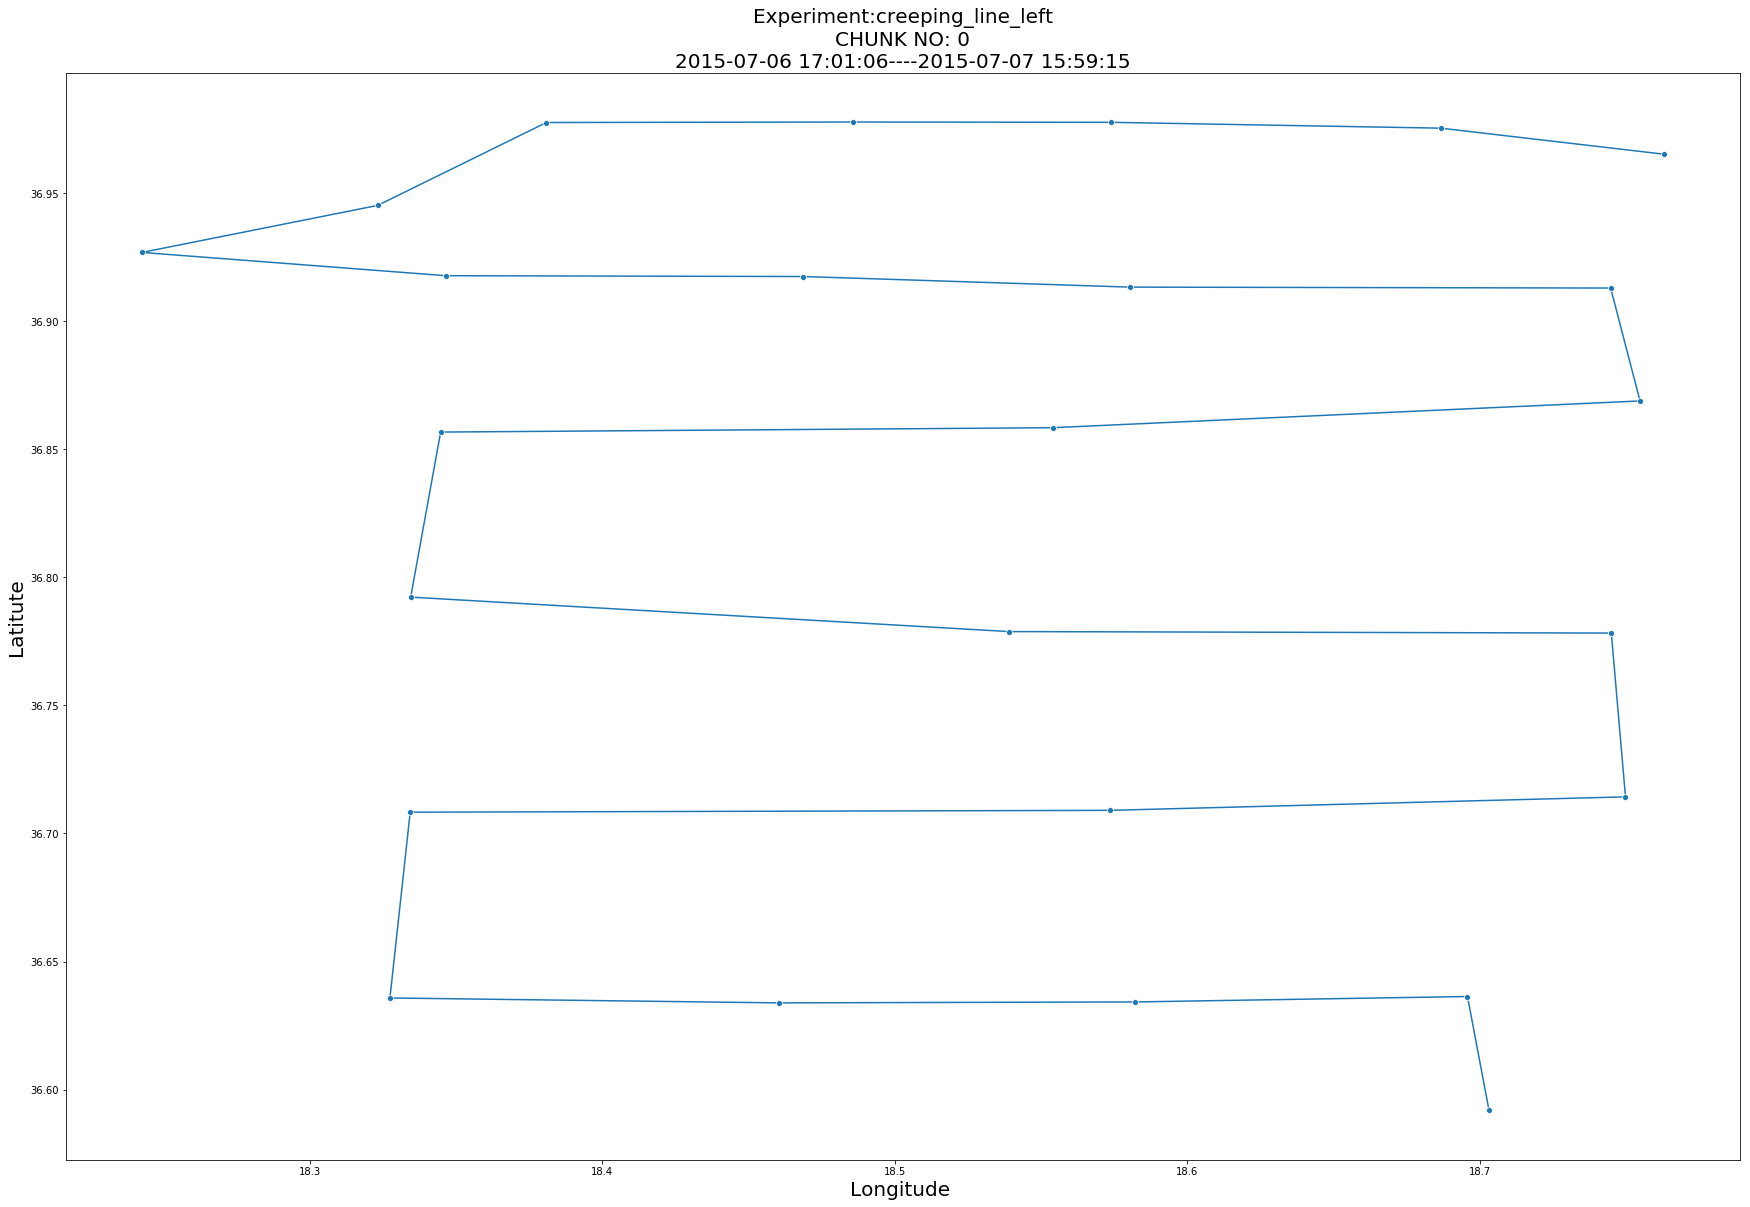

In [3]:
x = scale_down(real_data,train_test_options["split"])
x = np.array([x["HEADING"].values.astype(int)])
ship = {"shipname":"SIEM PILOT","data":x,"ship_dfs":[real_data]}
predictions,proba = experiments(ship,movement_list)
for idx,patt in enumerate(movement_list):
     print("found the pattern:",patt," with probability:",proba[idx][0][0]) if predictions[idx][0] == 0 else None
proba_info,pattern_indexes = results(movement_list,proba,predictions)
best_patterns = find_best_patterns(proba_info)
plots(movement_list=movement_list,pattern_indexes=pattern_indexes,best_patterns=best_patterns,ship_name=ship["shipname"],ship_dfs=ship["ship_dfs"])

Second case : check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of code is right with the use of rdp algorithm before the scale_down section

found the pattern: step_up_right  with probability: 0.9633600845477805
found the pattern: creeping_line_left  with probability: 0.9985632957694442
found the pattern: creeping_line_right  with probability: 0.9240444984099518
For chunk no: 0 the best pattern is  creeping_line_left


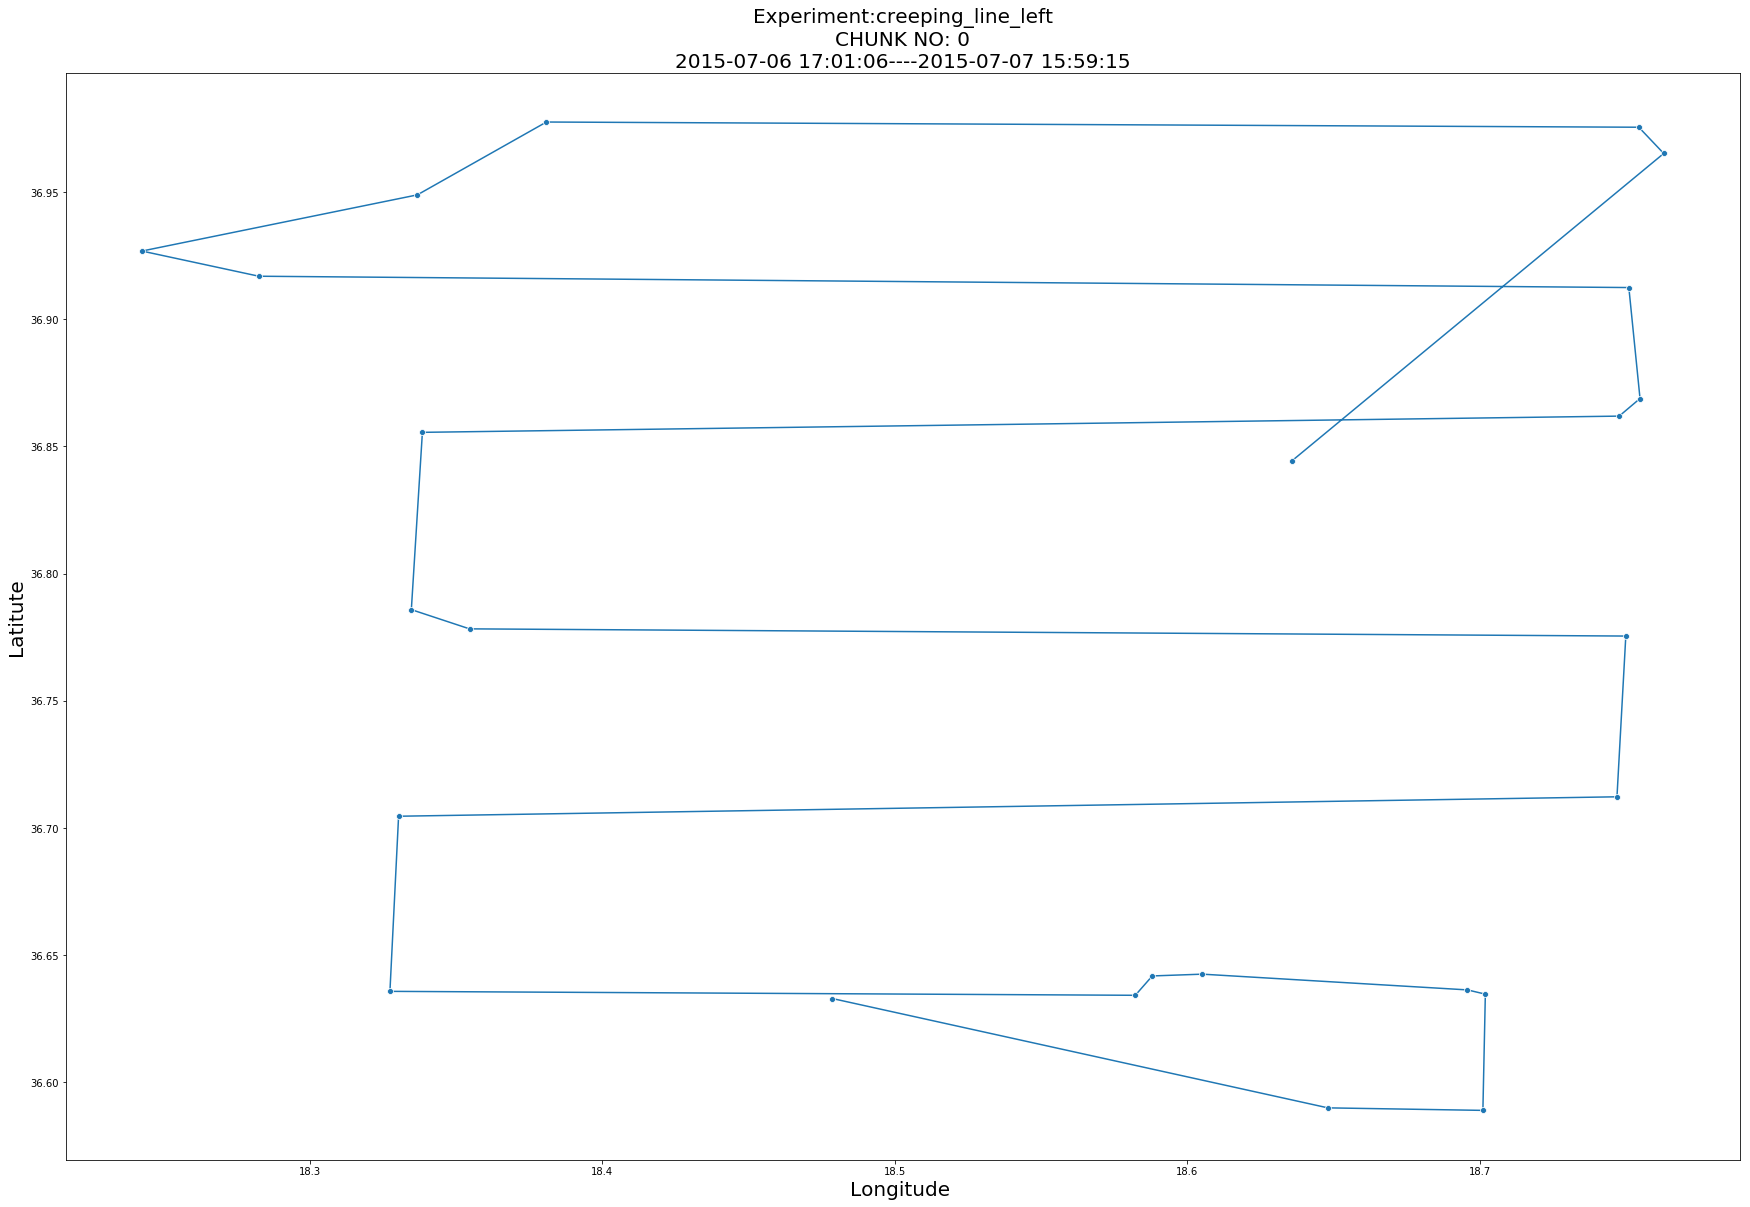

In [4]:
lat = np.array(real_data["LAT"])
lon = np.array(real_data["LON"])
np_real_data = [np.array([x,lon[idx]]) for idx,x in enumerate(lat)]
mask = rdp(np_real_data,algo="iter", return_mask=True,epsilon=0.005)
rdp_real_data =  real_data[mask]
if len(rdp_real_data) == train_test_options["split"]:
    rdp_x = scale_down(rdp_real_data,train_test_options["split"])
    rdp_x = np.array([rdp_x["HEADING"].values.astype(int)])
    rdp_ship = {"shipname":"SIEM PILOT","data":rdp_x,"ship_dfs":[rdp_real_data]}
    rdp_predictions,rdp_proba = experiments(rdp_ship,movement_list)
    for idx,patt in enumerate(movement_list):
         print("found the pattern:",patt," with probability:",rdp_proba[idx][0][0]) if rdp_predictions[idx][0] == 0 else None
    rdp_proba_info,rdp_pattern_indexes = results(movement_list,rdp_proba,rdp_predictions)
    rdp_best_patterns = find_best_patterns(rdp_proba_info)
    plots(movement_list=movement_list,pattern_indexes=rdp_pattern_indexes,best_patterns=rdp_best_patterns,ship_name=rdp_ship["shipname"],ship_dfs=rdp_ship["ship_dfs"])

Third case : check for a known case of pattern (creeping_line_left for SIEM PILOT ship) if the result of code is right with chunks with size 50-sample (from a trajectory with size 500-sample) using scale-down (found only 1 suitable chunk after scale down )

found the pattern: step_up_right  with probability: 0.9633600845477805
found the pattern: creeping_line_left  with probability: 0.9985632957694442
found the pattern: creeping_line_right  with probability: 0.9240444984099518
For chunk no: 0 the best pattern is  creeping_line_left


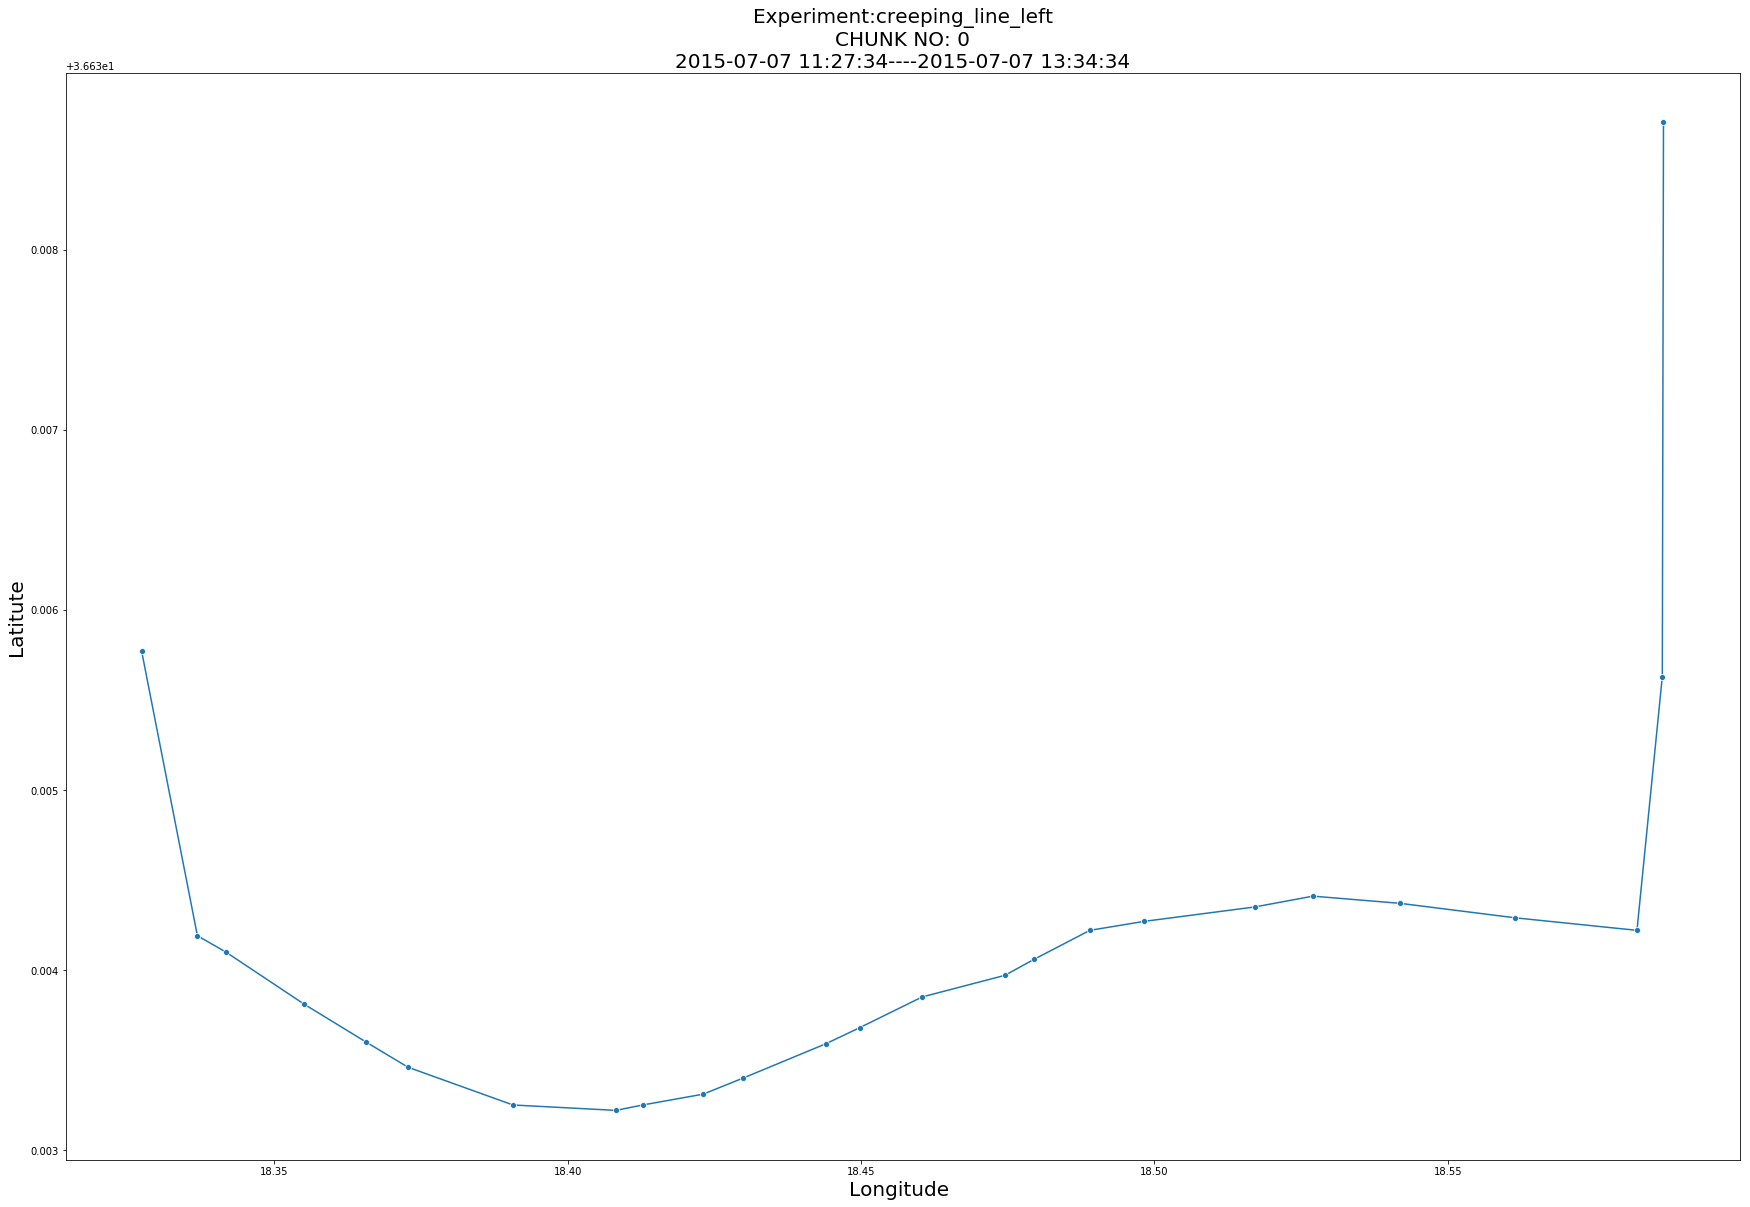

In [ ]:
n = 50  #chunk row size
small_ship_dfs = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
small_ship_data_chunked = []
small_ship_data_chunked_index = [False for i in range(0,len(small_ship_dfs))]  
for idx,small_x in enumerate(small_ship_dfs):
    small_x = scale_down(small_x,train_test_options["split"])
    small_x = np.array(small_x["HEADING"].values.astype(int))
    if len(small_x) == train_test_options["split"]:
        small_ship_data_chunked_index[idx] = True
        small_ship_data_chunked.append(small_x)
small_ship_data_chunked = np.array(small_ship_data_chunked)
small_ship_dfs = [small_ship for (small_ship,index) in zip(small_ship_dfs,small_ship_data_chunked_index) if  index ]
small_ship ={"shipname":"SIEM PILOT","data":small_ship_data_chunked,"ship_dfs":small_ship_dfs}
print("ERROR DIFFERENT SIZE OF DATA") if len(small_ship_dfs)!=small_ship["data"].shape[0] else None

small_predictions,small_proba = experiments(small_ship,movement_list)
for idx,patt in enumerate(movement_list):
    print("found the pattern:",patt," with probability:",small_proba[idx][0][0]) if small_predictions[idx][0] == 0 else None
small_proba_info,small_pattern_indexes = results(movement_list,small_proba,small_predictions)
small_best_patterns = find_best_patterns(small_proba_info)
plots(movement_list=movement_list,pattern_indexes=small_pattern_indexes,best_patterns=small_best_patterns,ship_name=small_ship["shipname"],ship_dfs=small_ship["ship_dfs"])


50-sample sized chunk plots of the  of the know SIEM PILOT's trajectory

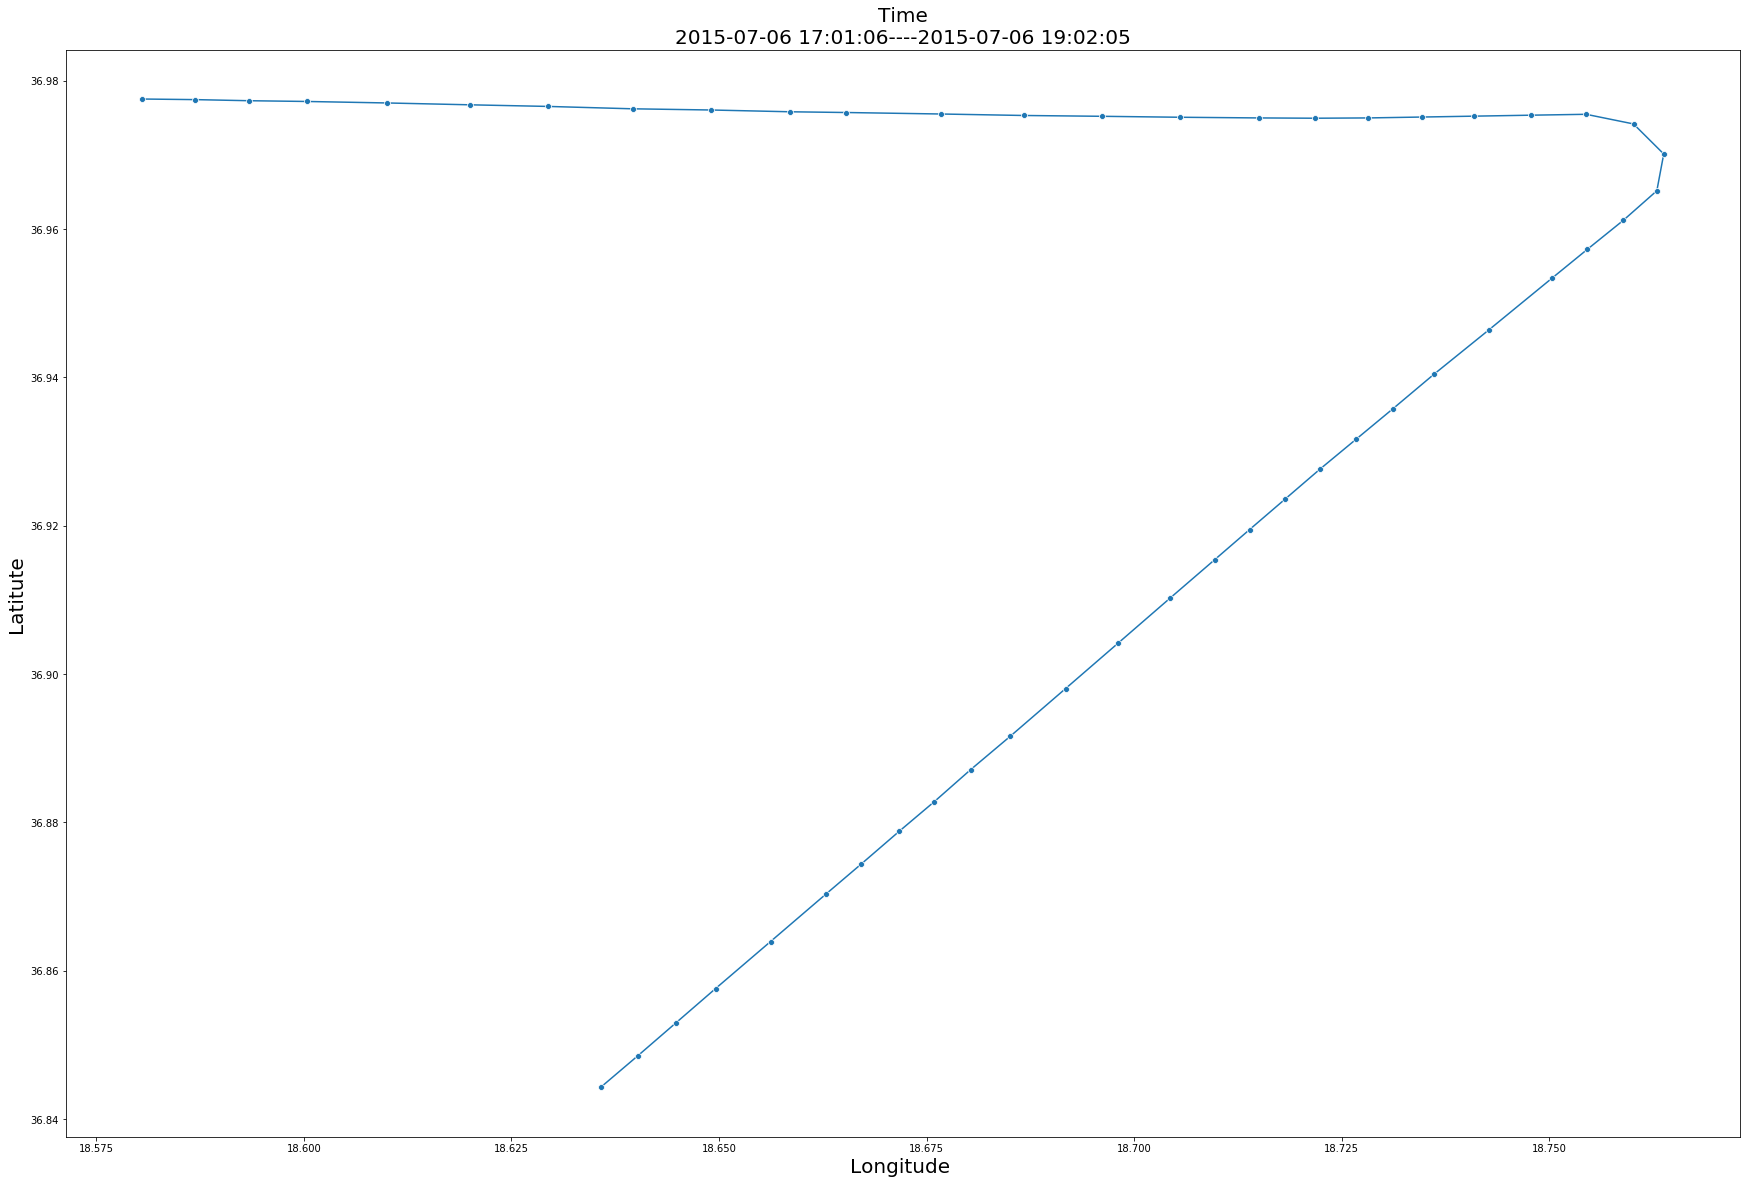

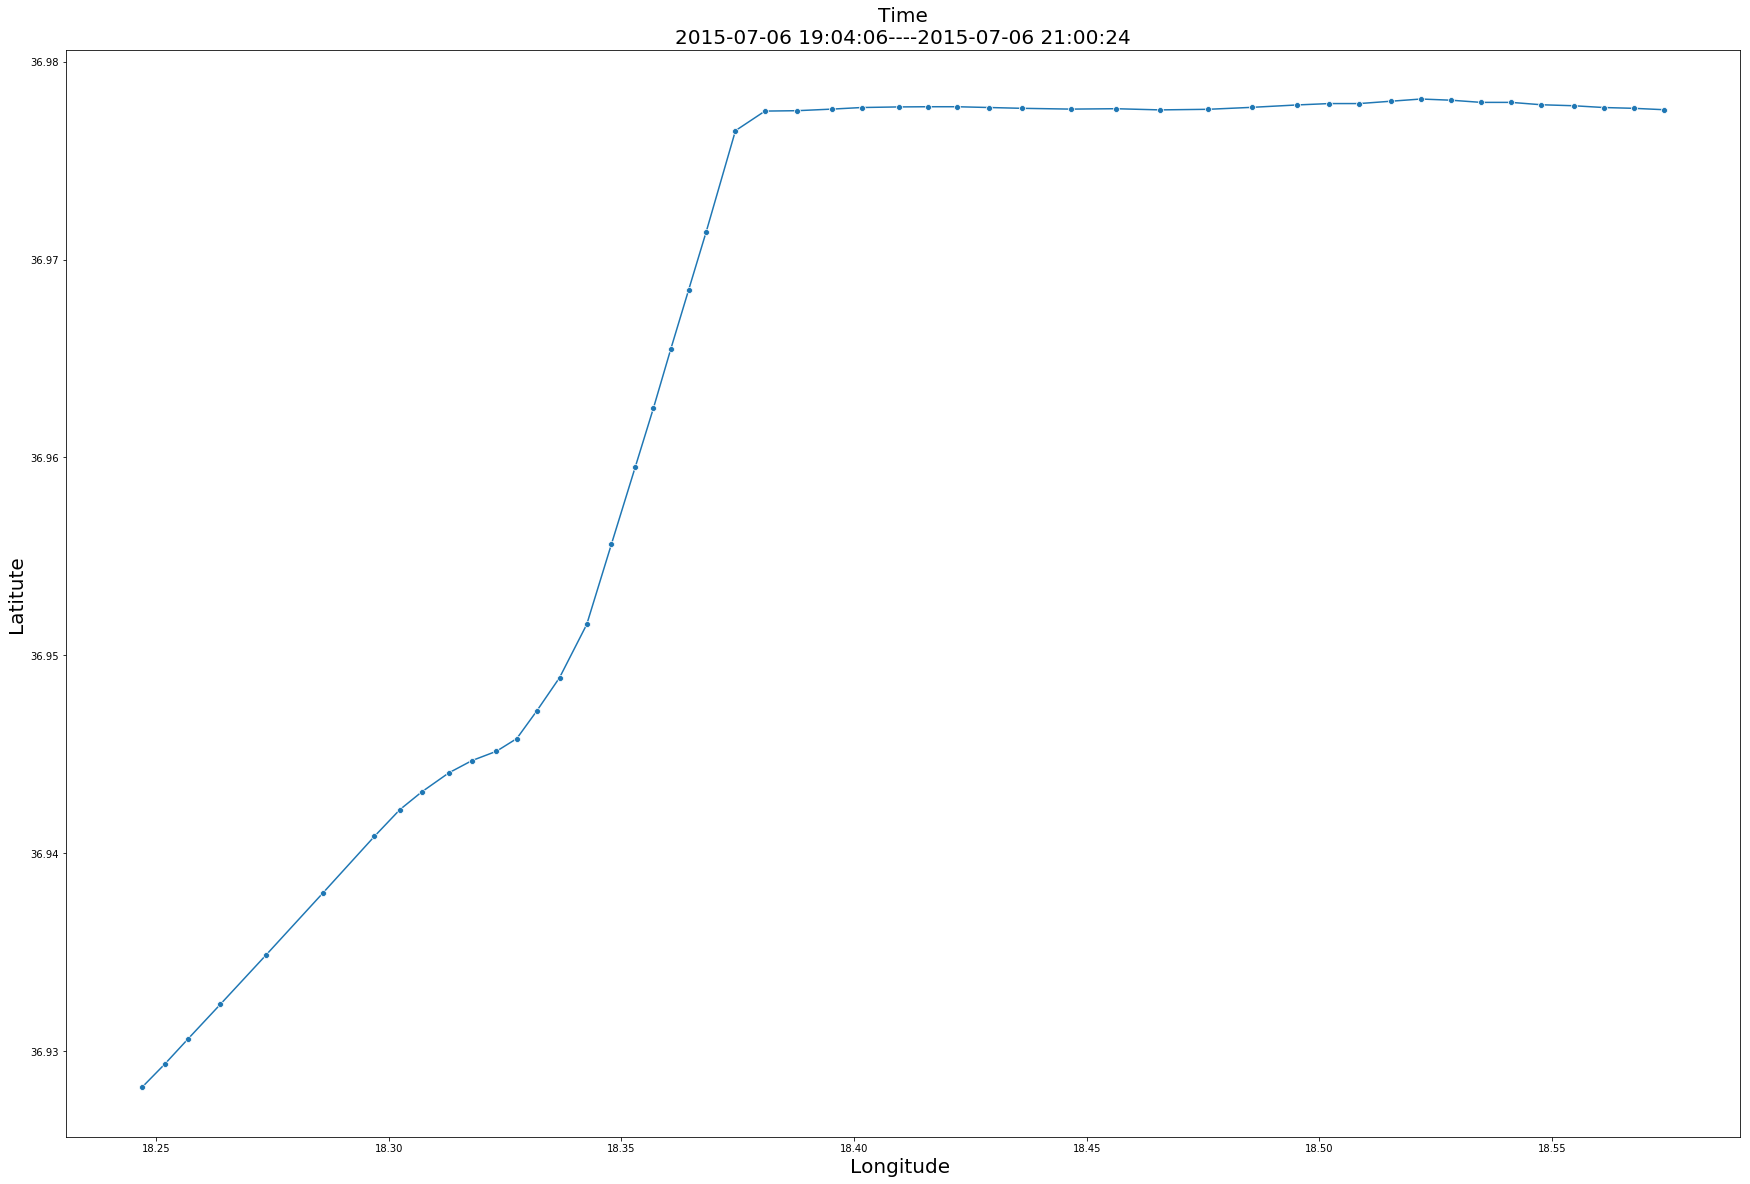

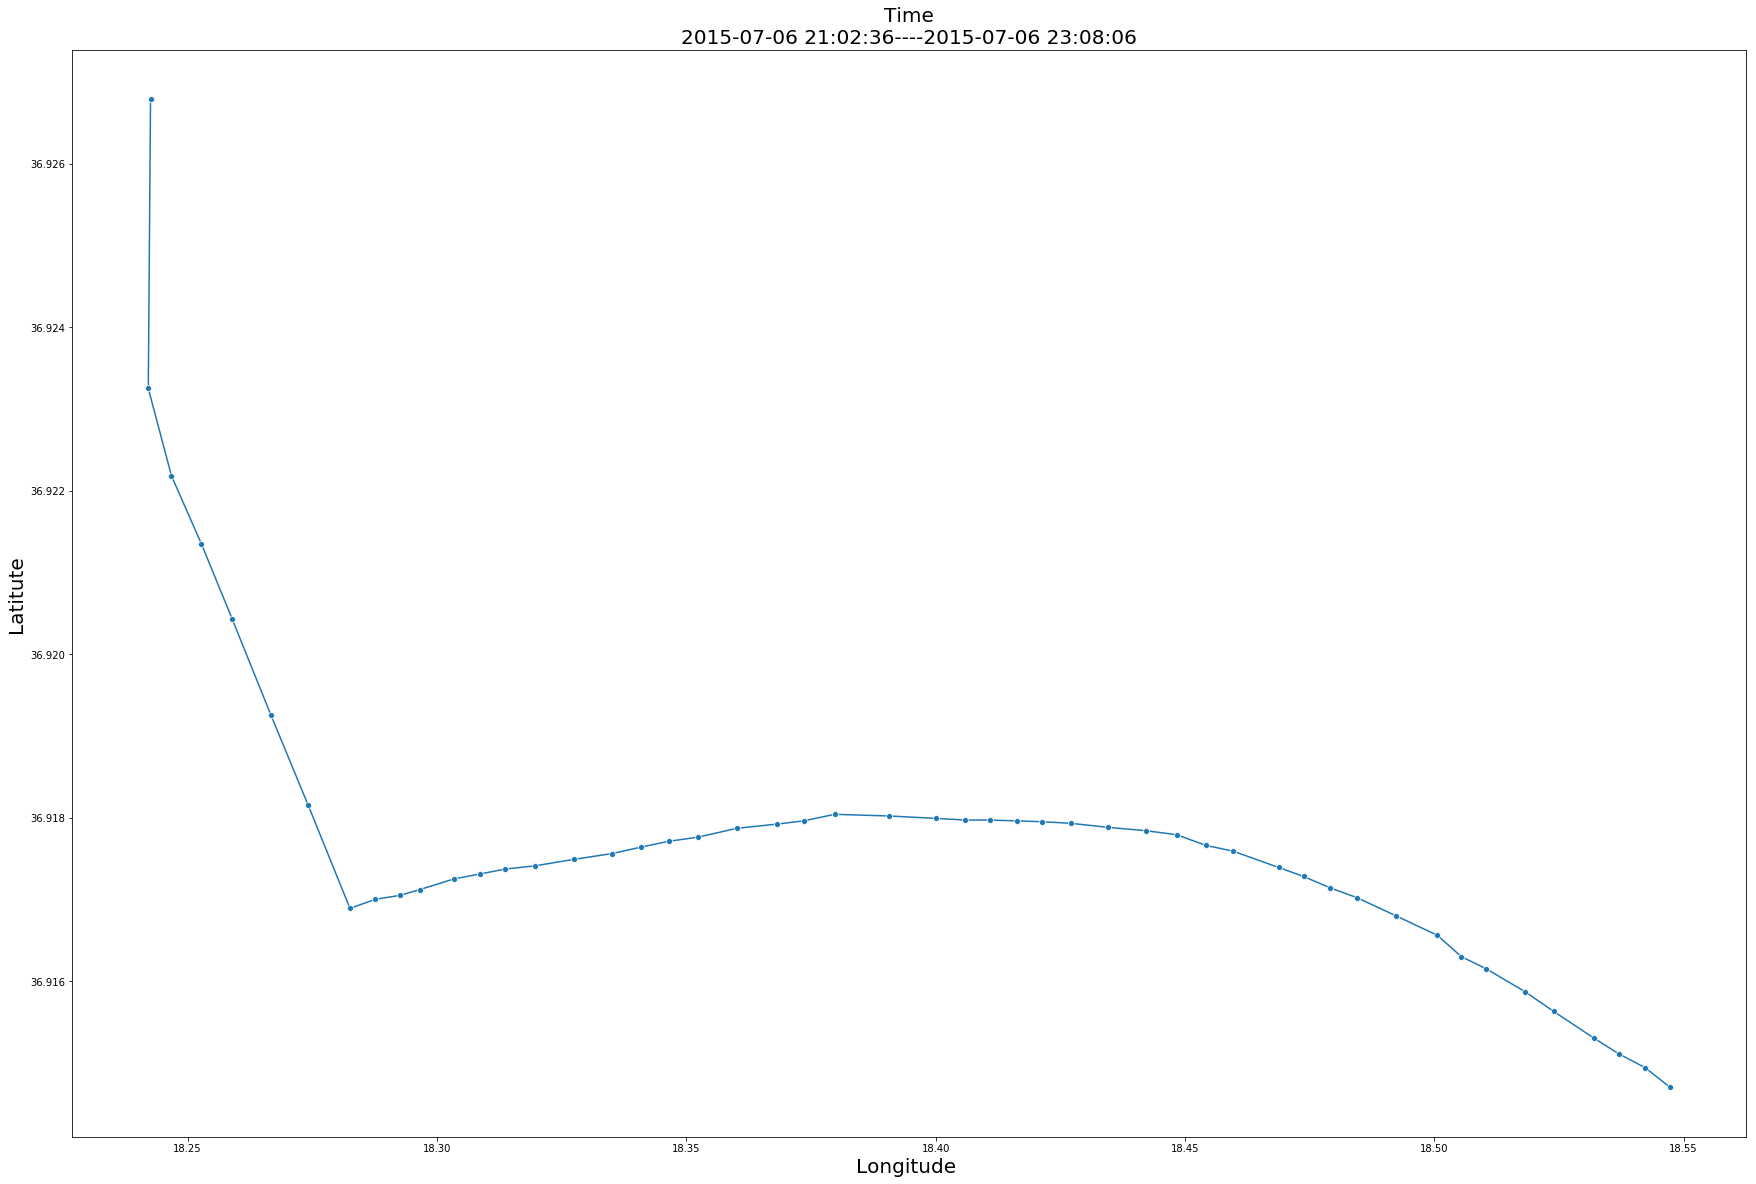

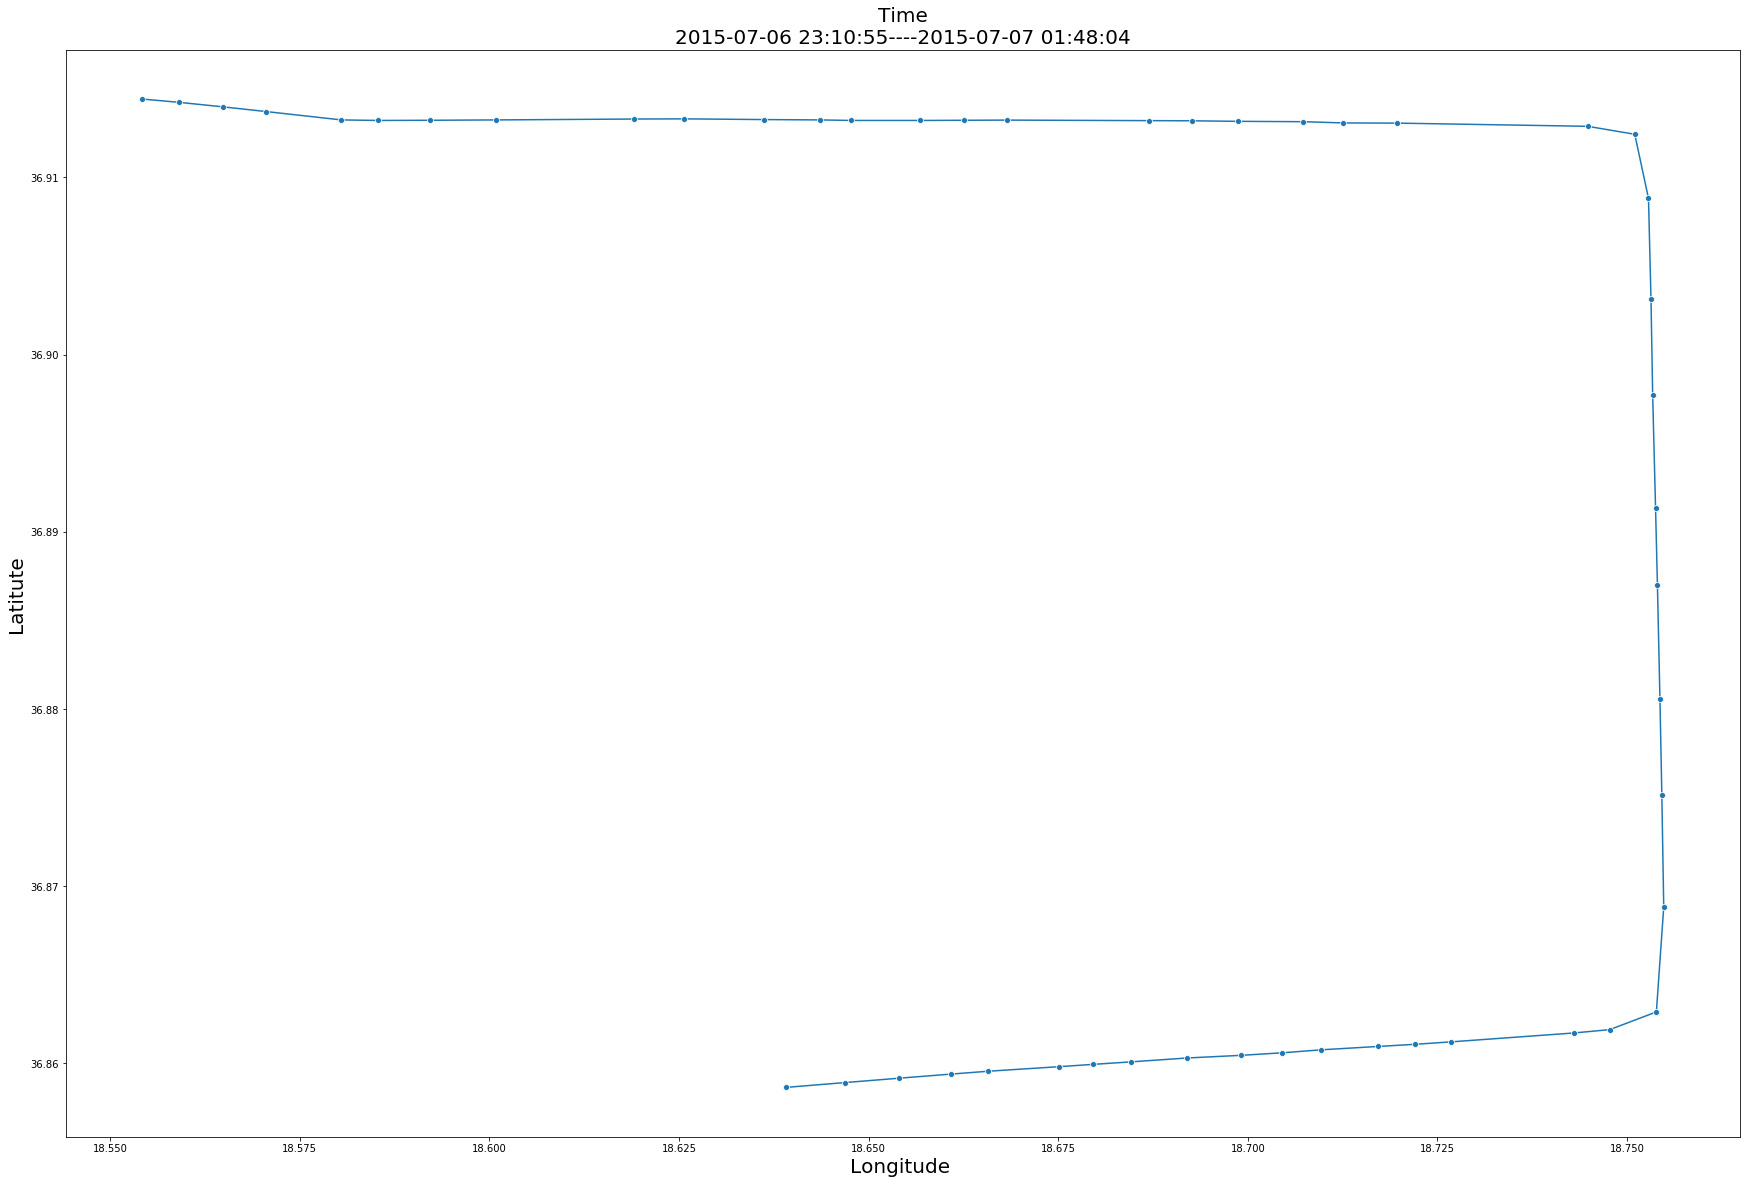

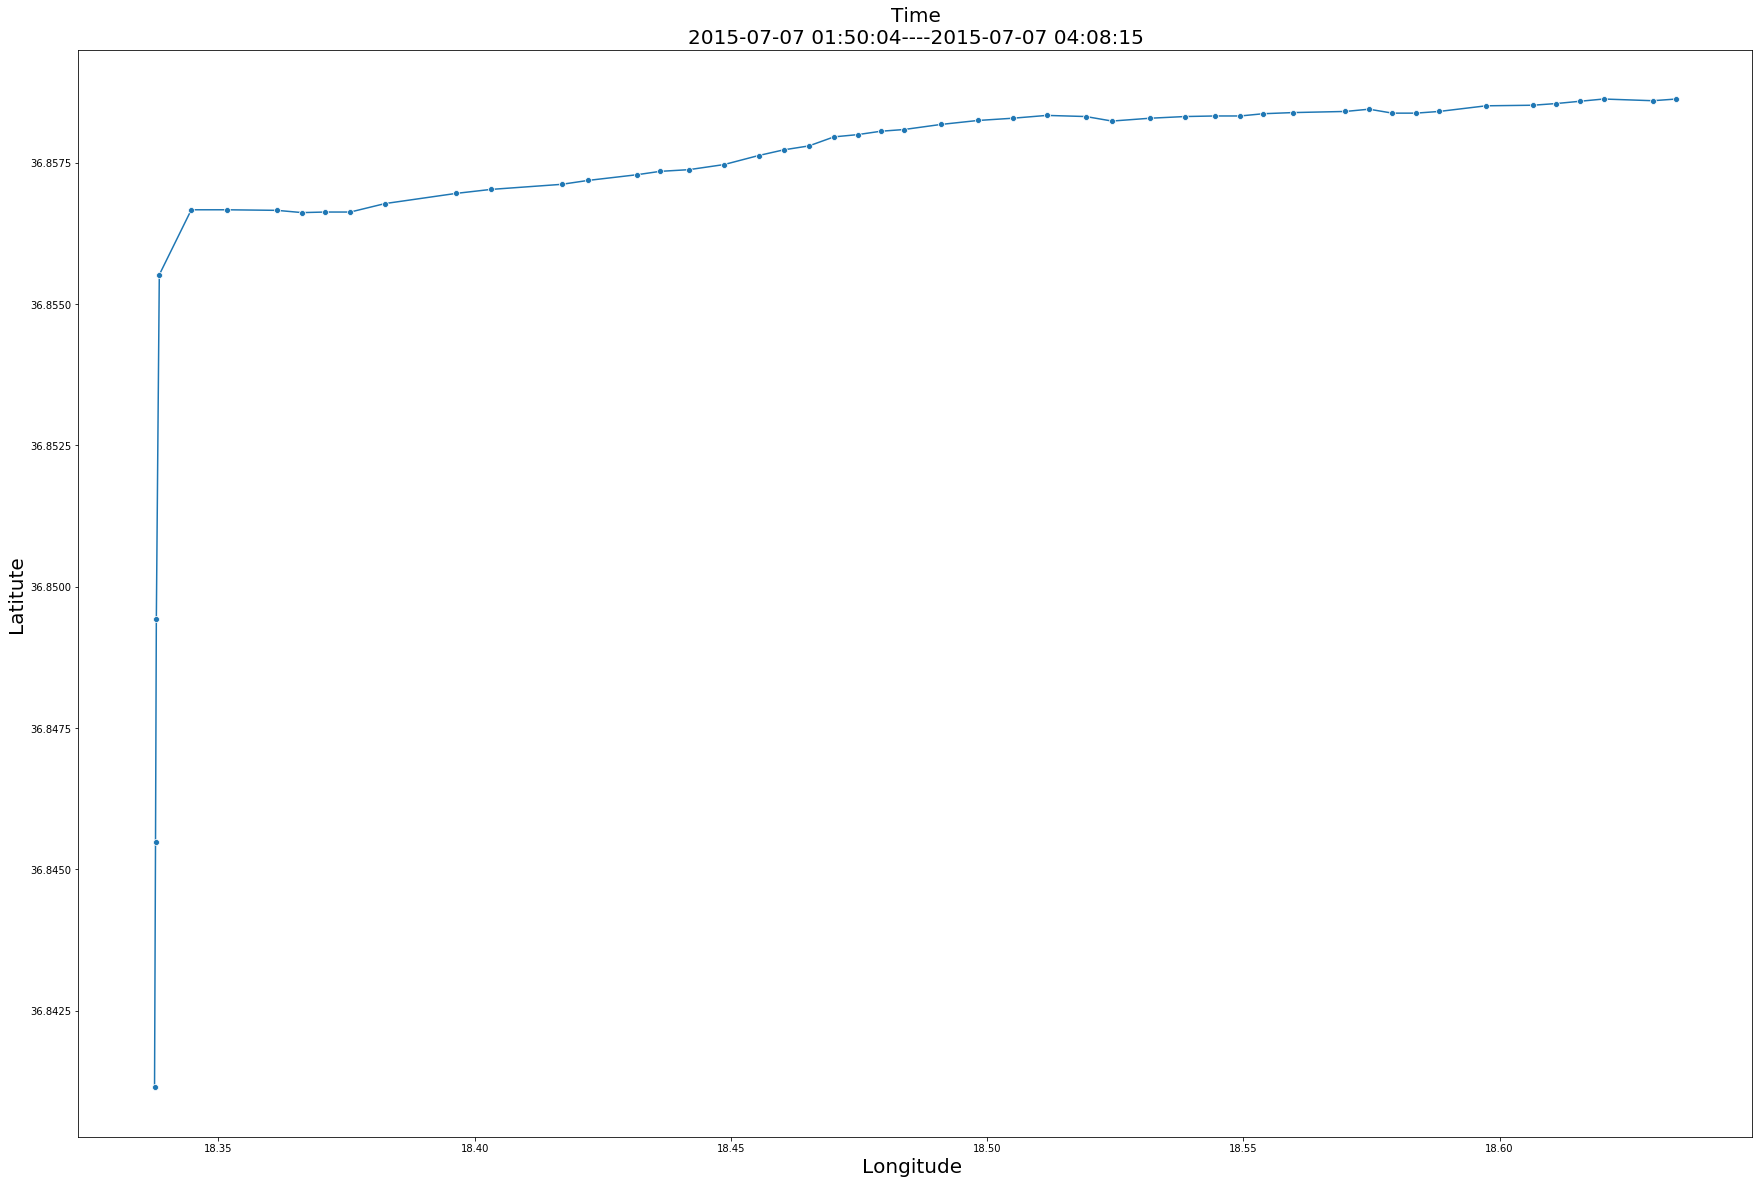

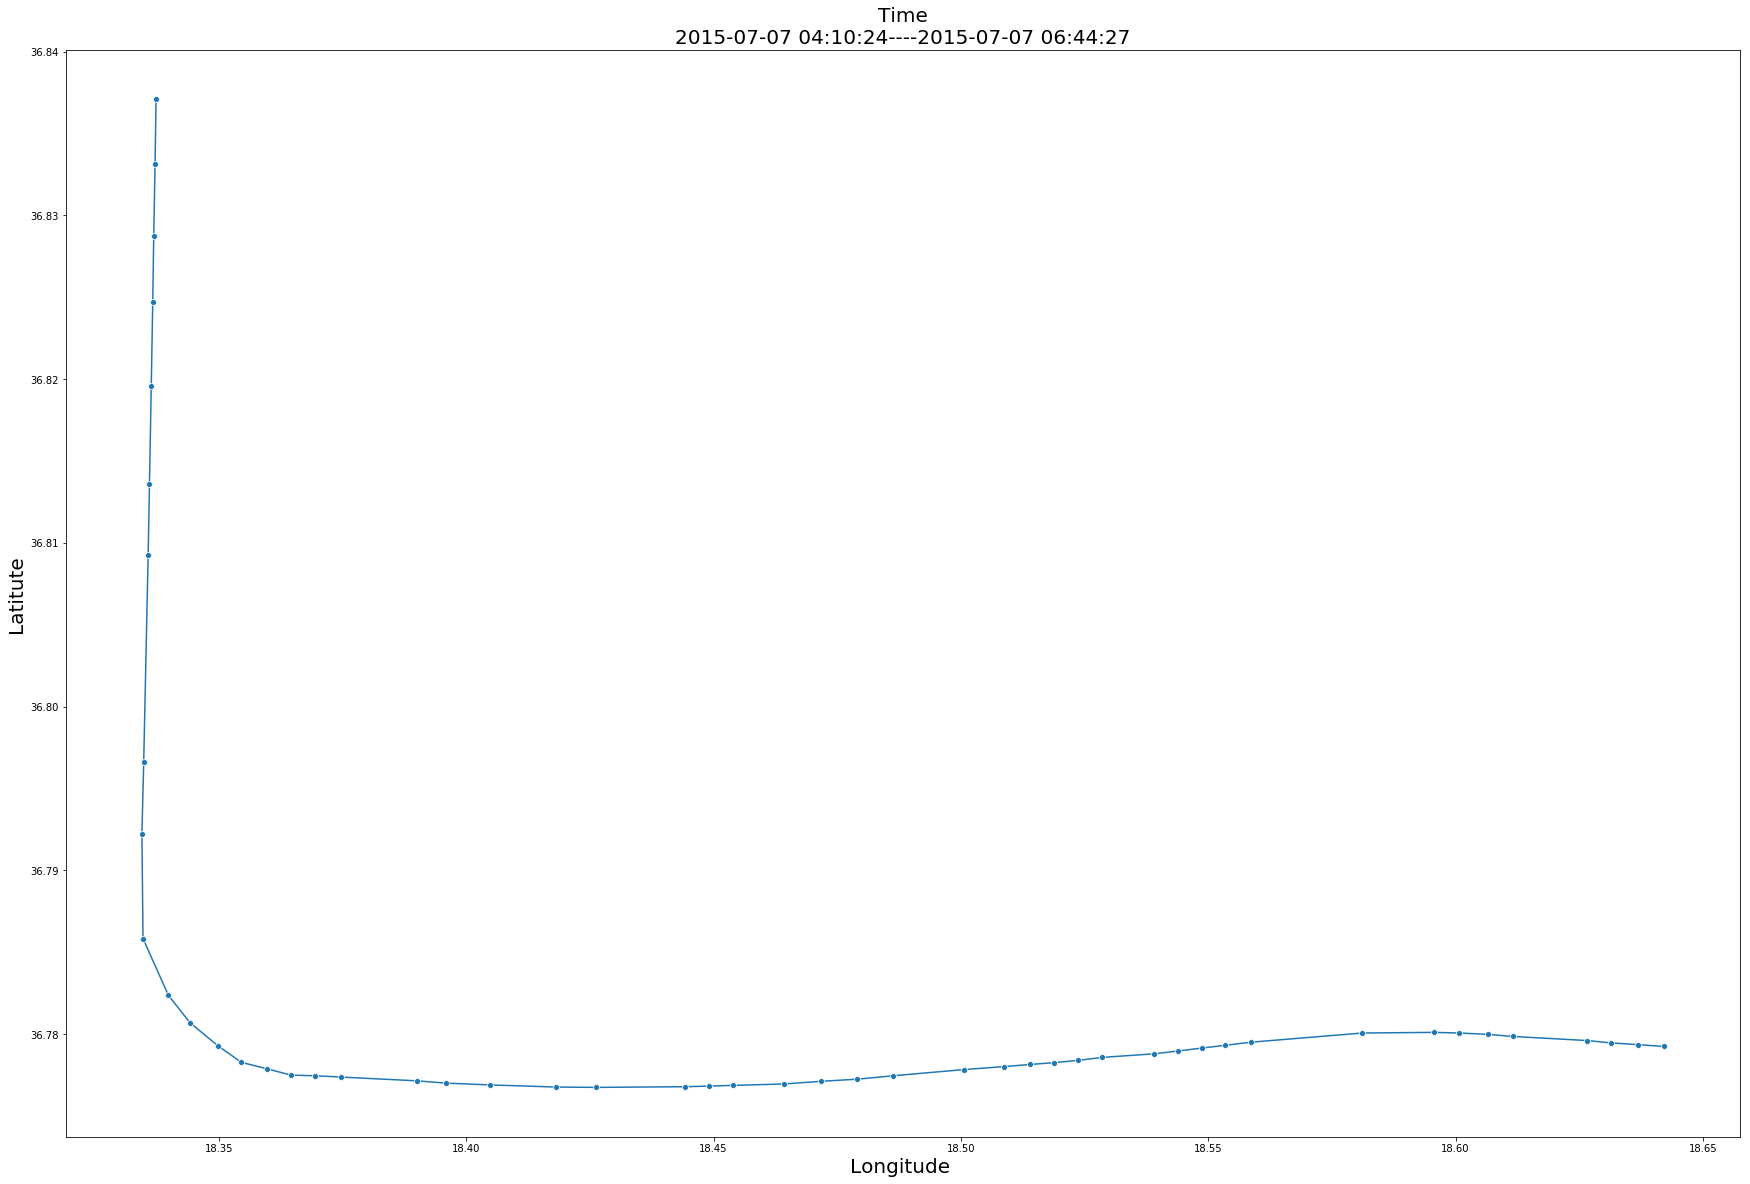

In [ ]:
small_ship_dfs_chunk = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
for p_ship in small_ship_dfs_chunk:
    fig, ax = plt.subplots()
    sns.lineplot(x='LON', y='LAT', data=p_ship, ax=ax,sort=False,marker="o")
    fig.set_size_inches(30, 20)
    ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
    ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
    start = datetime.strftime(p_ship["TIMESTAMP"].head(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    end = datetime.strftime(p_ship["TIMESTAMP"].tail(1).iloc[0],'%Y-%m-%d %H:%M:%S')
    title = "Time\n"+start+"----"+end
    ax.set_title(title,fontsize = 20.0)

fouth case: rerun of third case with rdp algorithm without scale down. The epsilon parameter is selected after extensive search in order to give 25-sample size trajectories

In [ ]:
def epsilon_selection(real_data,data,size):
    if len(real_data)<=size:
        return False
    else:
        epsilon = 0
        i = 0 
        mask_len = len(real_data)
        while mask_len!=size:
#             print("i:",i,mask_len,size,epsilon)
            mask = rdp(data,algo="iter", return_mask=True,epsilon=epsilon)
            mask_len = mask.count(True)
            if i >200:
                return False
            if mask_len < size:
                if size - mask_len <=1:
                    epsilon = epsilon - 0.0000000005
                else :
                    epsilon = epsilon - 0.000005
            else:
                if mask_len -size <=1:
                    epsilon = epsilon + 0.00000002
                else:
                    epsilon = epsilon + 0.000002
            i = i +1
        return mask


n = 50  #chunk row size
small_ship_dfs = [real_data[i:i+n] for i in range(0,real_data.shape[0],n)]
small_ship_data_chunked = []
small_ship_data_chunked_index = [False for i in range(0,len(small_ship_dfs))]  

for idx,small_x in enumerate(small_ship_dfs):
    small_lat = np.array(small_x["LAT"])
    small_lon = np.array(small_x["LON"])
    small_np_data= [np.array([x,small_lon[idx]]) for idx,x in enumerate(small_lat)]
    mask = epsilon_selection(small_x,small_np_data,train_test_options["split"])
    if mask:
        small_rdp_x =  small_x[mask]
        if len(small_rdp_x) == train_test_options["split"]:
            small_rdp_x = np.array(small_rdp_x["HEADING"].values.astype(int))
            small_ship_data_chunked_index[idx] = True
            small_ship_data_chunked.append(small_rdp_x)


small_ship_data_chunked = np.array(small_ship_data_chunked)
small_ship_dfs = [small_ship for (small_ship,index) in zip(small_ship_dfs,small_ship_data_chunked_index) if  index ]
small_rdp_ship ={"shipname":"SIEM PILOT","data":small_ship_data_chunked,"ship_dfs":small_ship_dfs}
print("ERROR DIFFERENT SIZE OF DATA") if len(small_ship_dfs)!=small_rdp_ship["data"].shape[0] else None

small_rdp_predictions,small_rdp_proba = experiments(small_rdp_ship,movement_list)
for idx,patt in enumerate(movement_list):
    for idpred,pred in enumerate(small_rdp_predictions[idx]):
        print("found the pattern:",patt," with probability:",small_rdp_proba[idx][idpred][0]) if pred== 0 else None
small_rdp_proba_info,small_rdp_pattern_indexes = results(movement_list,small_rdp_proba,small_rdp_predictions)
small_rdp_best_patterns = find_best_patterns(small_rdp_proba_info)
plots(movement_list=movement_list,pattern_indexes=small_rdp_pattern_indexes,best_patterns=small_rdp_best_patterns,ship_name=small_rdp_ship["shipname"],ship_dfs=small_rdp_ship["ship_dfs"],scaled_down=False)

In [ ]:
for idx,patt in enumerate(movement_list):
    for idpred,pred in enumerate(small_rdp_predictions[idx]):
        print("found the pattern:",patt," with probability:",small_rdp_proba[idx][idpred][0]) if pred== 0 else None